In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import time
import pickle
import os

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score

import random, os, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dropout, Dense
from tensorflow.keras import backend as K


import sys
sys.path.append("../")
import methods
import utils_models 
import utils_interpretability


from mpl_toolkits.axes_grid1 import make_axes_locatable

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [2]:
n_time_steps = 14
norm = "robustNorm"

# Explainability. Heatmaps 


In [3]:
features =  ['AMG', 'CAR', 'CF1', 'CF3', 'CF4',
            'Others', 'GLI', 'LIN', 'LIP', 'MAC', 'NTI', 'OXA', 'PAP', 'PEN', 'POL',
            'QUI', 'SUL', 'MV hours', 'Acinet$_{pc}$', 'Enterobac$_{pc}$', 'Enteroc$_{pc}$',
            'Pseud$_{pc}$', 'Staph$_{pc}$', 'Others$_{pc}$', 'ICU$_{hours}$',
            '# pat$_{atb}$', '# pat$_{MDR}$',
            'CAR$_{n}$', 'PAP$_{n}$', 
            'Others$_{n}$', 'QUI$_{n}$',
            'OXA$_{n}$', 'PEN$_{n}$', 'CF3$_{n}$', 'GLI$_{n}$',
            'CF4$_{n}$', 'SUL$_{n}$', 'NTI$_{n}$', 'LIN$_{n}$',
            'AMG$_{n}$', 'MAC$_{n}$', 'CF1$_{n}$', 'POL$_{n}$',
            'LIP$_{n}$', '# pat$_{tot}$' ,'Post change',
            'Insulin', 'Art nutrition', 'Sedation', 'Relax', 'Hepatic$_{fail}$',
            'Renal$_{fail}$', 'Coagulation$_{fail}$', 'Hemodynamic$_{fail}$',
            'Respiratory$_{fail}$', 'Multiorganic$_{fail}$',  '# transfusions',
            'Vasoactive drug', 'Dosis nems', 'Tracheo$_{hours}$', 'Ulcer$_{hours}$',
            'Hemo$_{hours}$', 'C01 PIVC 1',
            'C01 PIVC 2', 'C02 CVC - RJ',
            'C02 CVC - RS', 'C02 CVC - LS', 'C02 CVC - RF',
            'C02 CVC - LJ', 'C02 CVC - LF', '# catheters']


new_order = ['AMG', 'CAR', 'CF1', 'CF3', 'CF4',
            'Others', 'GLI', 'LIN', 'LIP', 'MAC', 'NTI', 'OXA', 'PAP', 'PEN', 'POL',
            'QUI', 'SUL','# pat$_{atb}$', '# pat$_{MDR}$', '# pat$_{tot}$', 'CAR$_{n}$', 'PAP$_{n}$', 
            'Others$_{n}$', 'QUI$_{n}$',
            'OXA$_{n}$', 'PEN$_{n}$', 'CF3$_{n}$', 'GLI$_{n}$',
            'CF4$_{n}$', 'SUL$_{n}$', 'NTI$_{n}$', 'LIN$_{n}$',
            'AMG$_{n}$', 'MAC$_{n}$', 'CF1$_{n}$', 'POL$_{n}$',
            'LIP$_{n}$', 'Acinet$_{pc}$', 'Enterobac$_{pc}$', 'Enteroc$_{pc}$',
            'Pseud$_{pc}$', 'Staph$_{pc}$', 'Others$_{pc}$',
            'Post change',
            'Insulin', 'Art nutrition', 'Sedation', 'Relax', 'MV hours', 'Respiratory$_{fail}$','Hepatic$_{fail}$',
            'Renal$_{fail}$', 'Coagulation$_{fail}$', 'Hemodynamic$_{fail}$',
            'Multiorganic$_{fail}$', '# transfusions',
            'Vasoactive drug', 'Dosis nems', 'Tracheo$_{hours}$', 'Ulcer$_{hours}$',
            'Hemo$_{hours}$', 'ICU$_{hours}$', 'C01 PIVC 1',
            'C01 PIVC 2', 'C02 CVC - RJ',
            'C02 CVC - RS', 'C02 CVC - LS', 'C02 CVC - RF',
            'C02 CVC - LJ', 'C02 CVC - LF', '# catheters']

feature_to_index = {feature: idx for idx, feature in enumerate(features)}
new_indices = [feature_to_index[feature] for feature in new_order]

In [4]:
directory = './Results_GRU_Had'
def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

hadamard_scores_data = load_from_pickle(os.path.join(directory, "hadamard_scores_data.pkl"))

## Visualization

## MDR patients

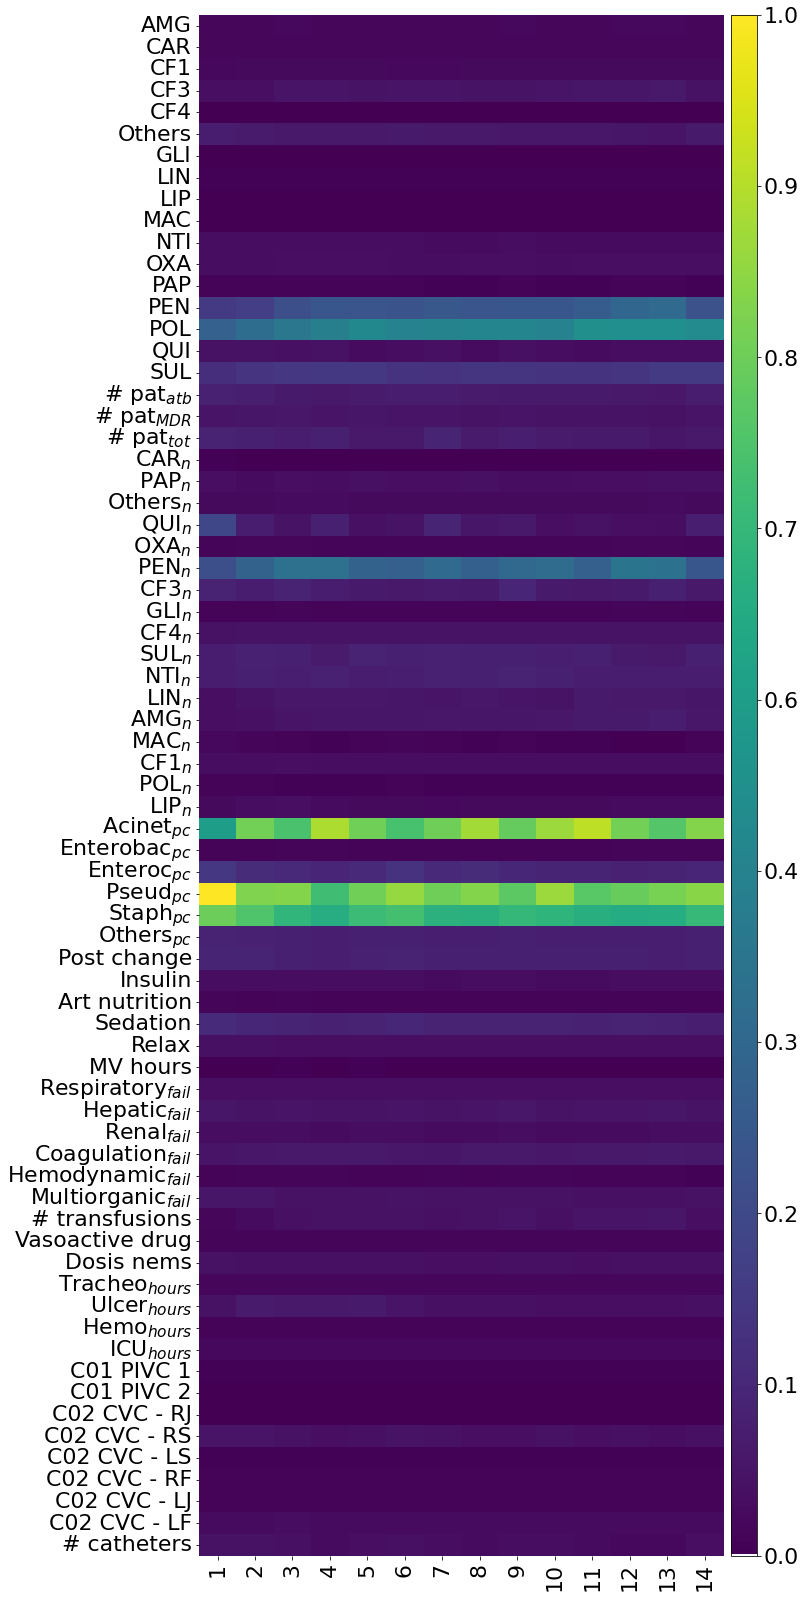

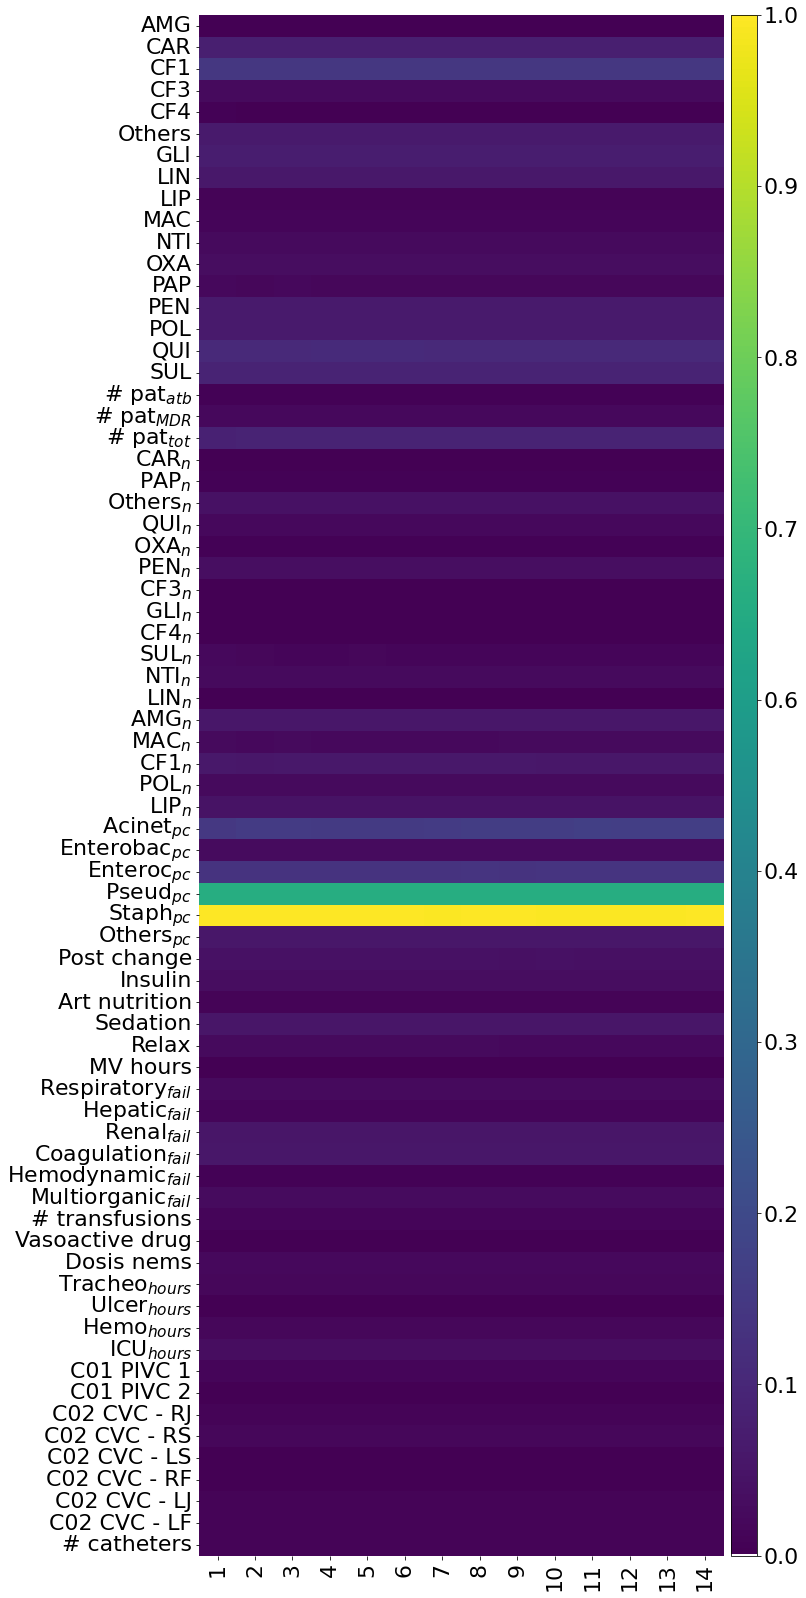

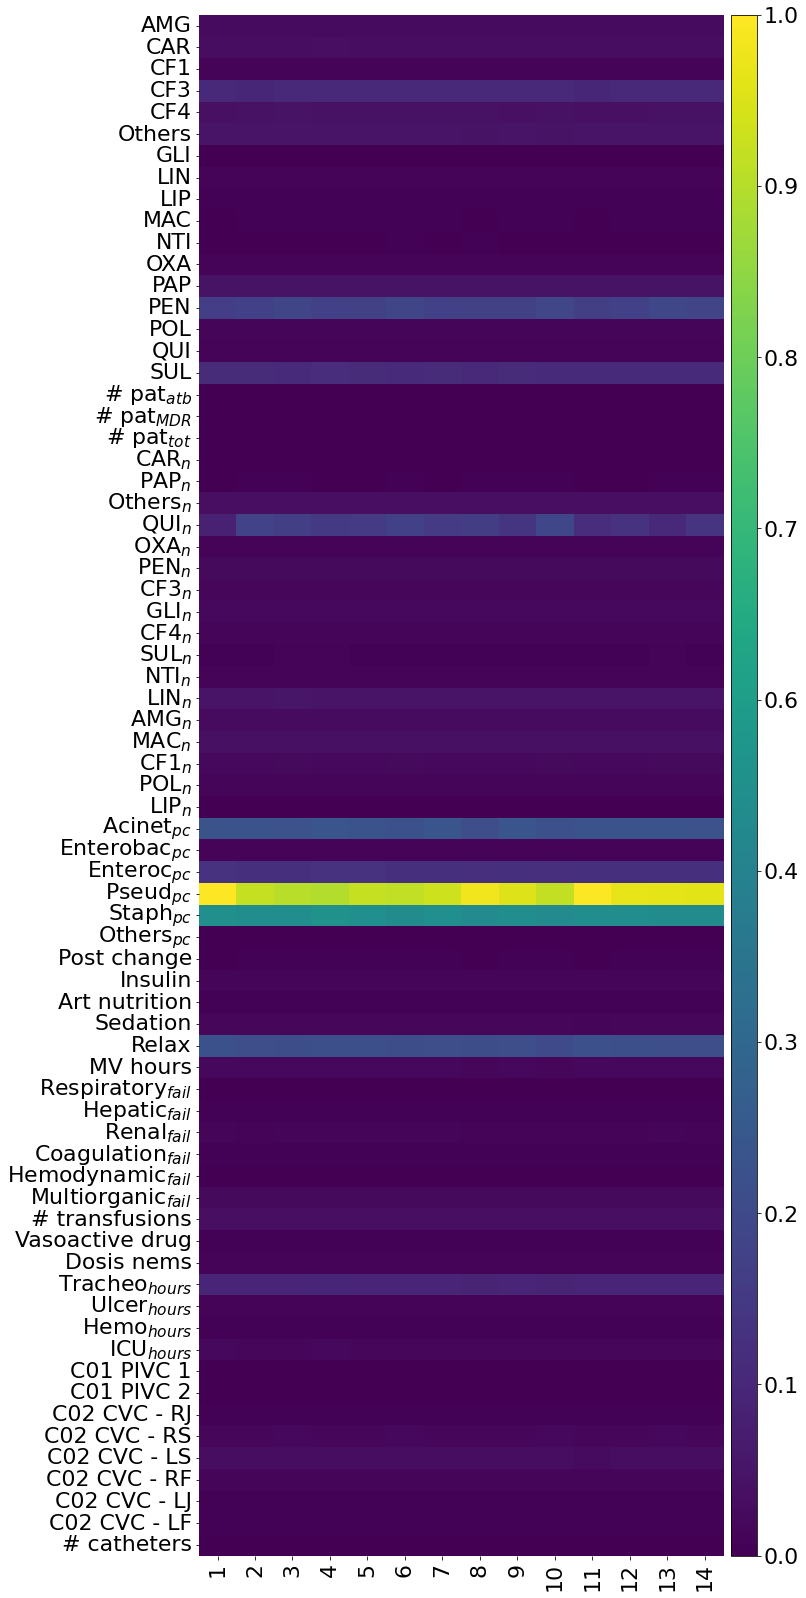

In [5]:
dfsplits_amr = []

for i in range(1,4):
    X_test = np.load(f"../../DATA/BBCET_cult_ok_19062024/s{i}/X_test_tensor_{norm}.npy")    
    y_test_or = pd.read_csv(f"../../DATA/BBCET_cult_ok_19062024/s{i}/y_test_tensor_{norm}.csv")
    y_test = y_test_or[y_test_or.individualMRGerm != 666]
    y_test = y_test.groupby(by="Admissiondboid").sum().reset_index()
    amr = y_test[y_test.individualMRGerm != 0].index

    y_test_or = y_test_or.loc[:, 'individualMRGerm'].values.reshape(y_test_or.shape[0] // n_time_steps, n_time_steps)
    weights = hadamard_scores_data[i-1][0]
    
    #### AMR PATIENTS
    # Step 1: Find the indexes where y_test_or is equal to 1
    idx_amr = np.where(y_test_or == 1)
    # Step 2: Create a boolean mask with the same shape as y_test_or
    mask = np.full(y_test_or.shape, False)
    mask[idx_amr] = True
    # Step 3: Create an array of NaNs with the same shape as weights
    nan_weights = np.full(weights.shape, np.nan)
    # Step 4: Copy the weights elements where mask is True
    nan_weights[mask] = weights[mask]

    dfsplits_amr.append(nan_weights)
    average_weights_amr = np.nanmean(nan_weights, axis=0) / np.nanmean(nan_weights, axis=0).max()
    reordered_average_weights_amr = average_weights_amr.T[new_indices, :]

    plt.figure(figsize=(11,22))
    ax = plt.gca()
    heatmap = sns.heatmap(
        reordered_average_weights_amr,
        cmap='viridis',
        xticklabels=np.arange(reordered_average_weights_amr.shape[1]) + 1,  # Set x-axis tick labels
        yticklabels=new_order,
        ax=ax,
        cbar=False  # Disable the default color bar
    )

    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=22)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=22, rotation=90)

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = heatmap.figure.colorbar(heatmap.collections[0], cax=cax)
    cbar.ax.tick_params(labelsize=22)

    # Set custom ticks on the colorbar with the first value as 0
    num_ticks = 10  # Set the number of ticks you want
    tick_locs = np.linspace(0, 1, num_ticks)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in tick_locs])
    cbar.ax.tick_params(labelsize=22)

    plt.tight_layout(pad=0)
    plt.savefig('../Figures_VF/GRU_Had_mdr_s'+str(i)+'.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()


## Non-MDR patients

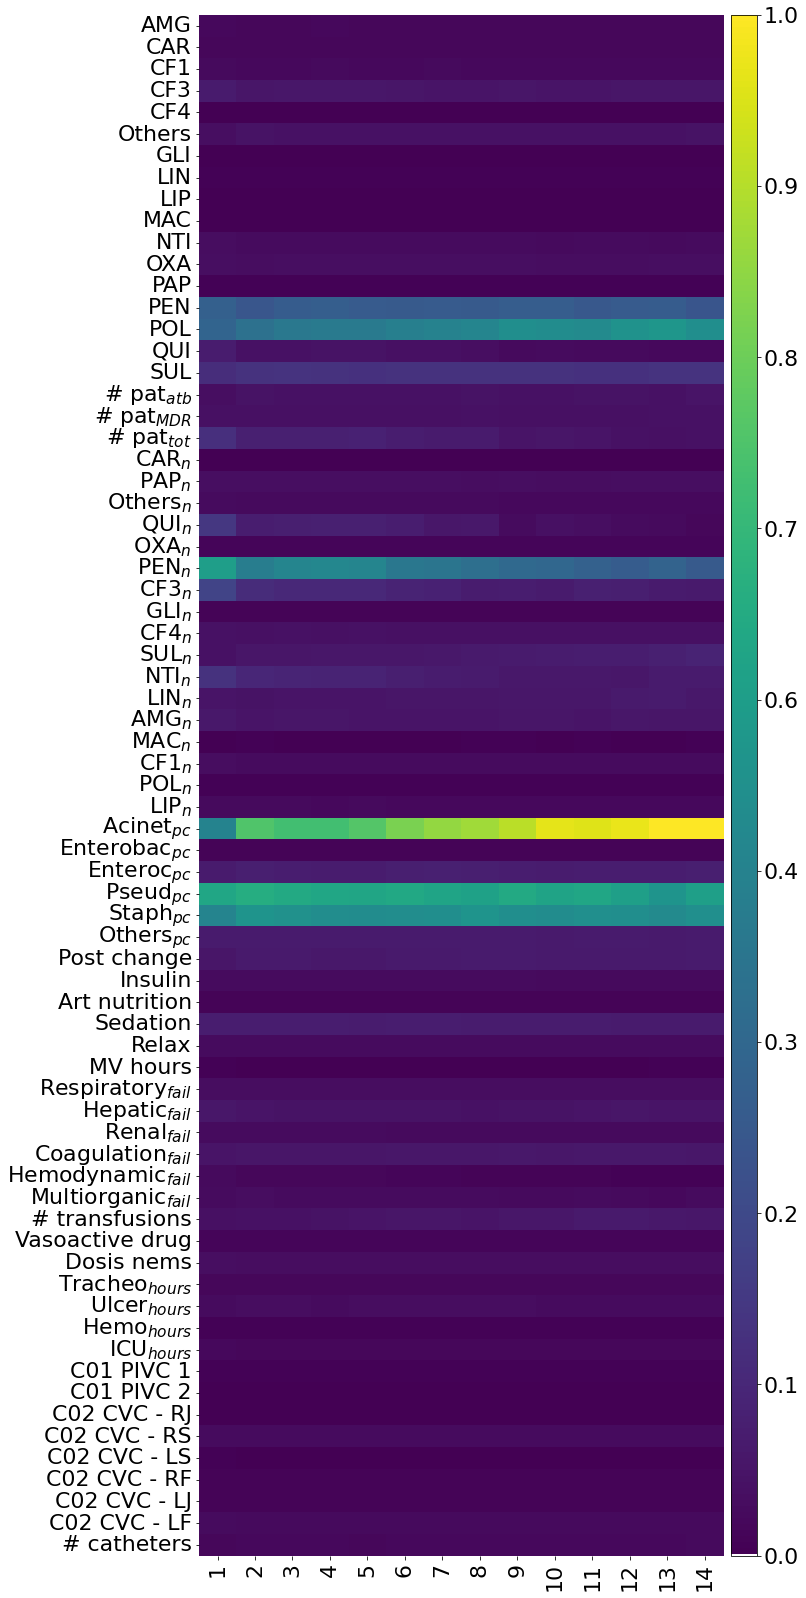

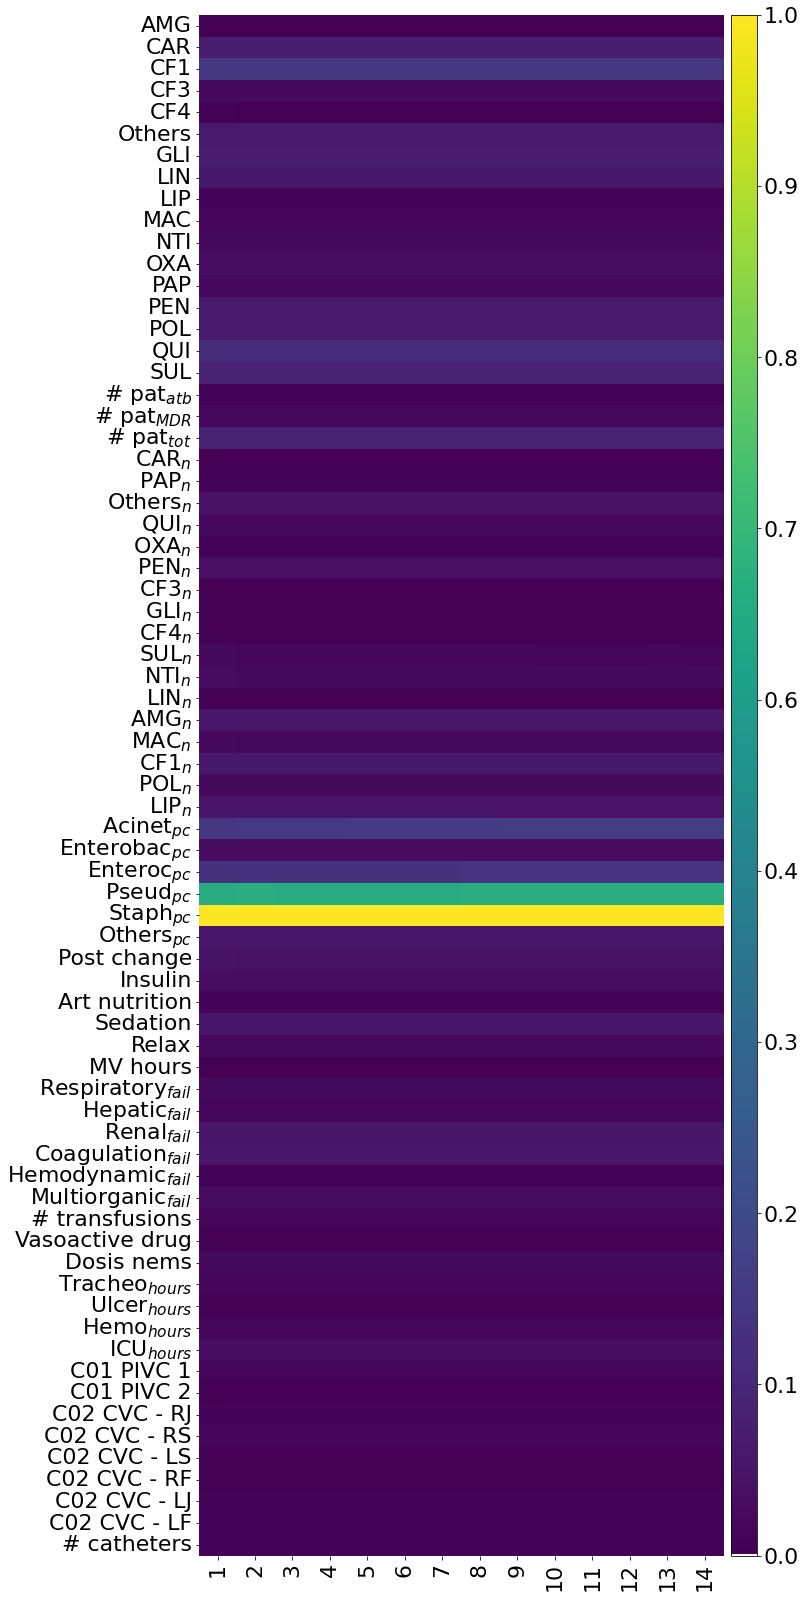

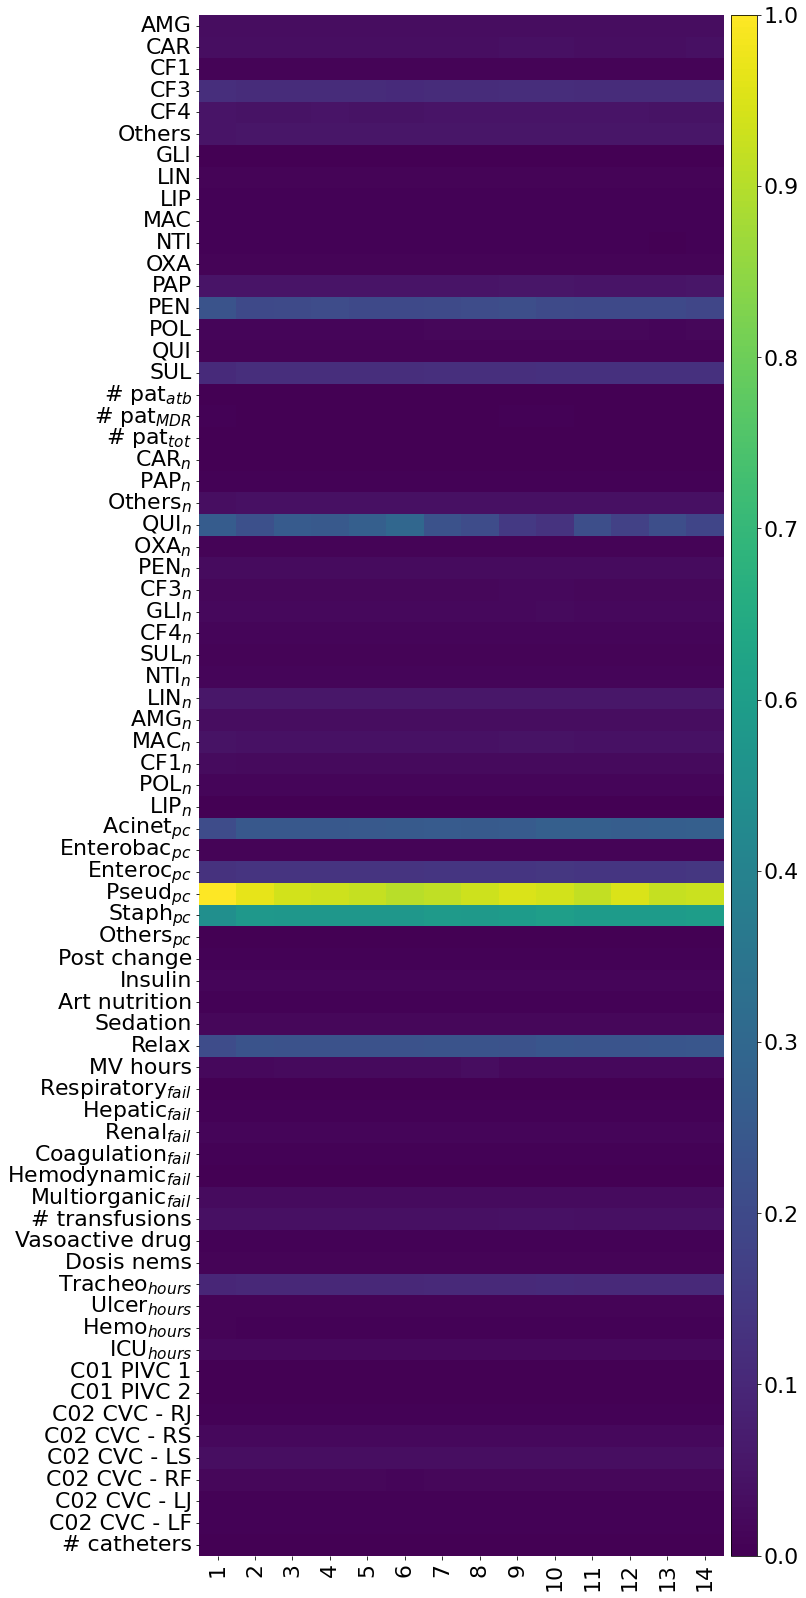

In [6]:
dfsplits_noamr = []
for i in range(1,4):
    X_test = np.load(f"../../DATA/BBCET_cult_ok_19062024/s{i}/X_test_tensor_{norm}.npy")    
    y_test_or = pd.read_csv(f"../../DATA/BBCET_cult_ok_19062024/s{i}/y_test_tensor_{norm}.csv")
    y_test = y_test_or[y_test_or.individualMRGerm != 666]
    y_test = y_test.groupby(by="Admissiondboid").sum().reset_index()
    amr = y_test[y_test.individualMRGerm != 0].index
    noamr = y_test[y_test.individualMRGerm == 0].index

    y_test_or = y_test_or.loc[:, 'individualMRGerm'].values.reshape(y_test_or.shape[0] // n_time_steps, n_time_steps)
    weights = hadamard_scores_data[i-1][0]
    #### NON AMR PATIENTS
    # Step 1: Find the indexes where y_test_or is equal to 0
    idx_noamr = np.where(y_test_or == 0)
    # Step 2: Create a boolean mask with the same shape as y_test_or
    mask = np.full(y_test_or.shape, False)
    mask[idx_noamr] = True
    # Step 3: Create an array of NaNs with the same shape as weights
    nan_weights = np.full(weights.shape, np.nan)
    # Step 4: Copy the weights elements where mask is True
    nan_weights[mask] = weights[mask]
    dfsplits_noamr.append(nan_weights)

    average_weights_noamr = np.nanmean(nan_weights, axis=0) / np.nanmean(nan_weights, axis=0).max()
    
    reordered_average_weights_noamr = average_weights_noamr.T[new_indices, :]
    
    plt.figure(figsize=(11,22))
    ax = plt.gca()
    heatmap = sns.heatmap(
        reordered_average_weights_noamr,
        cmap='viridis',
        xticklabels=np.arange(reordered_average_weights_noamr.shape[1]) + 1,  # Set x-axis tick labels
        yticklabels=new_order,
        ax=ax,
        cbar=False  # Disable the default color bar
    )

    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=22)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=22, rotation=90)

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = heatmap.figure.colorbar(heatmap.collections[0], cax=cax)
    cbar.ax.tick_params(labelsize=22)

    # Set custom ticks on the colorbar with the first value as 0
    num_ticks = 10  # Set the number of ticks you want
    tick_locs = np.linspace(0, 1, num_ticks)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in tick_locs])
    cbar.ax.tick_params(labelsize=22)

    plt.tight_layout(pad=0)
    plt.savefig('../Figures_VF/GRU_Had_nomdr_s'+str(i)+'.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

## Population analysis

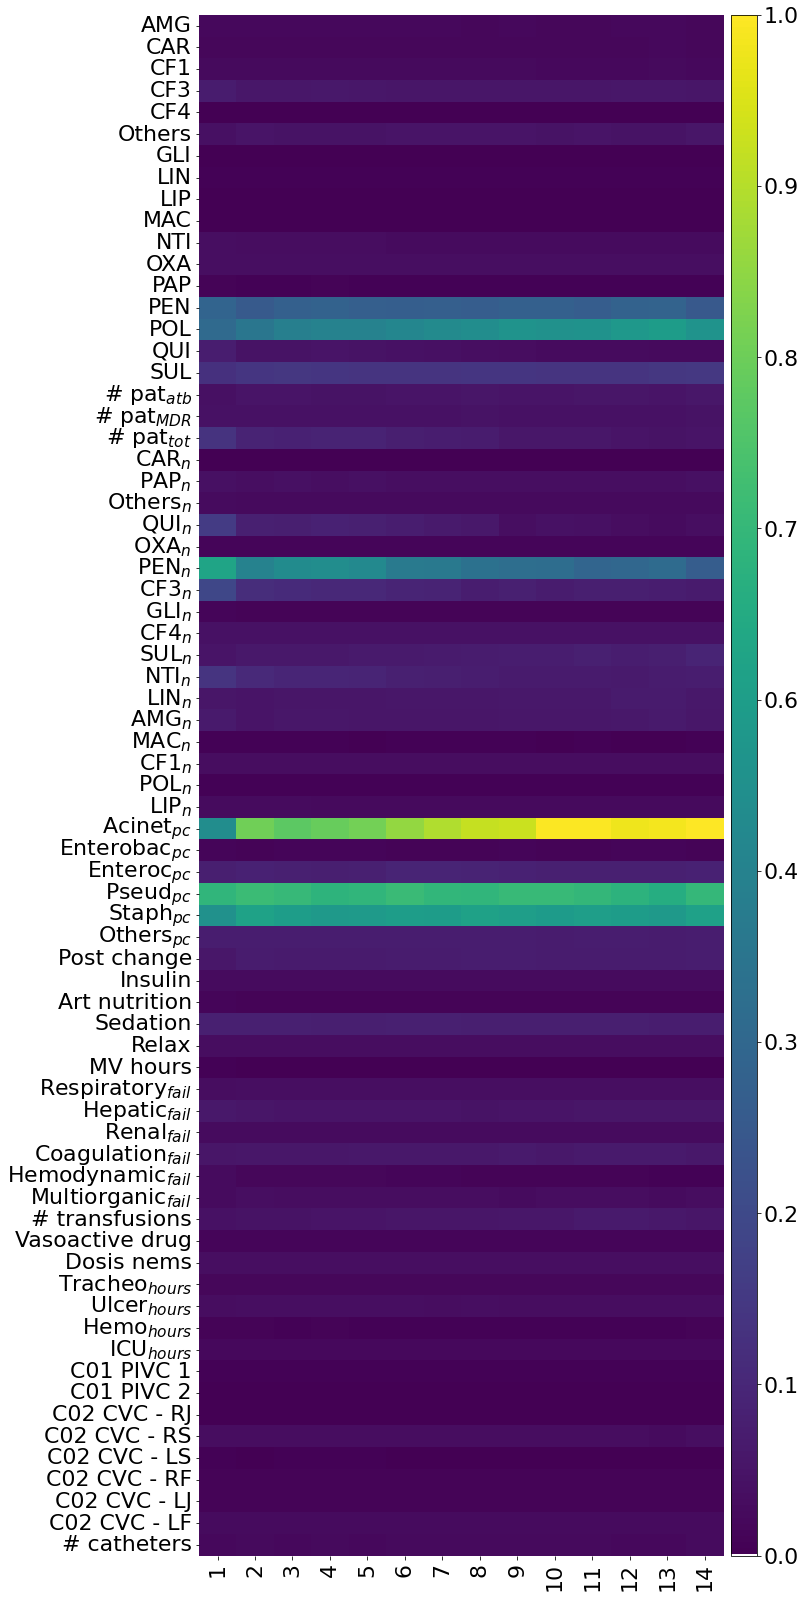

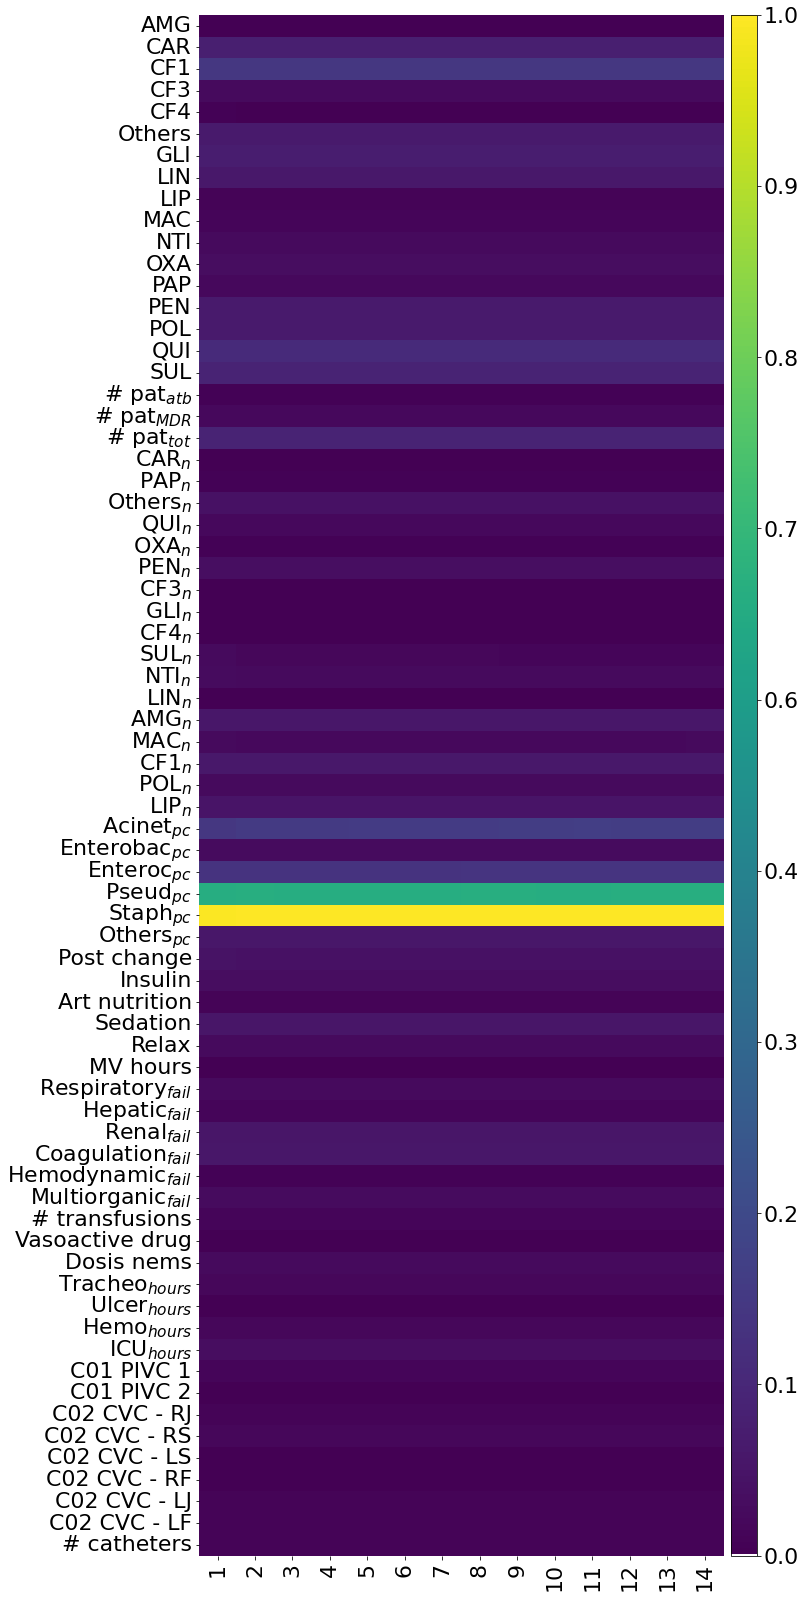

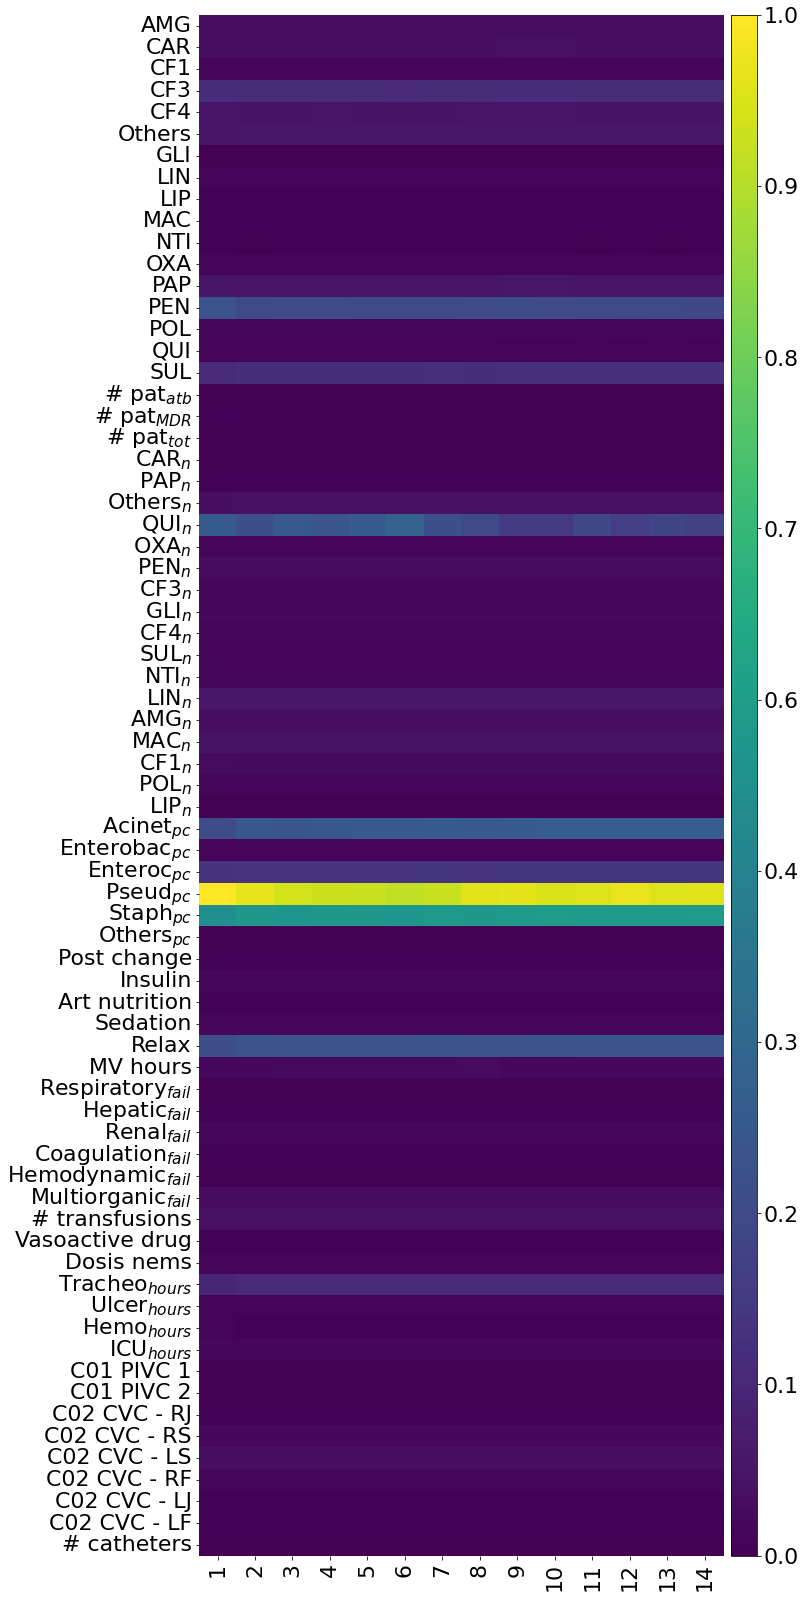

In [7]:
dfsplits_pop = []

for i in range(1,4):
    
    X_test = np.load(f"../../DATA/BBCET_cult_ok_19062024/s{i}/X_test_tensor_{norm}.npy")    
    
    weights = hadamard_scores_data[i-1][0]

    matrix= np.zeros(weights.shape)

    for j in range(weights.shape[2]):
        matrix[:, :, j] = np.where(X_test[:, :, j] == 666, np.nan, weights[:, :, j])

    dfsplits_pop.append(matrix)
    
    average_weights_pop = np.nanmean(matrix, axis=0) / np.nanmean(matrix, axis=0).max()

    reordered_average_weights_pop = average_weights_pop.T[new_indices, :]
    
    plt.figure(figsize=(11,22))
    ax = plt.gca()
    heatmap = sns.heatmap(
        reordered_average_weights_pop,
        cmap='viridis',
        xticklabels=np.arange(reordered_average_weights_pop.shape[1]) + 1,  # Set x-axis tick labels
        yticklabels=new_order,
        ax=ax,
        cbar=False  # Disable the default color bar
    )

    heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=22)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=22, rotation=90)

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = heatmap.figure.colorbar(heatmap.collections[0], cax=cax)
    cbar.ax.tick_params(labelsize=22)

    # Set custom ticks on the colorbar with the first value as 0
    num_ticks = 10  # Set the number of ticks you want
    tick_locs = np.linspace(0, 1, num_ticks)
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels([f'{tick:.1f}' for tick in tick_locs])
    cbar.ax.tick_params(labelsize=22)

    plt.tight_layout(pad=0)
    plt.savefig('../Figures_VF/GRU_Had_population_s'+str(i)+'.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()